# **Deep Learning Notebook**

This notebook trains and evaluates a Long Short-Term Memory (LSTM) model using PyTorch on the processed financial data:

- Train LSTM neural network model on the engineered sequential features.
- Perform hyperparameter optimization using Optuna to find the best model configuration.
- Evaluate model performance by comparing predictions against actual target values.
- Visualize model effectiveness through evaluation metrics.

---

## **Import required libraries**

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler
from optuna.trial import Trial
from optuna.exceptions import TrialPruned
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset

from huggingface_hub import hf_hub_download

## **Set Random Seed for Reproducibility**

In [2]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

## **Get the train and test datasets**

> **Download them or create the data from the `2.feature-engineering.ipynb` file.**

In [3]:
files_to_download = [
    "processed/train_dataset.parquet",
    "processed/test_dataset.parquet"
]

for file_path in files_to_download:
    hf_hub_download(
        repo_id="Sierra-Arn/finml-lab-data",
        filename=file_path,
        repo_type="dataset",
        local_dir="../data"
    )

In [4]:
TRAIN_DATASET = pd.read_parquet("../data/processed/train_dataset.parquet")
TEST_DATASET = pd.read_parquet("../data/processed/test_dataset.parquet")

## **Creating time series sequences for target**

In [5]:
WINDOW_SIZE = 5

def create_lstm_sequences(df: pd.DataFrame, window_size = WINDOW_SIZE):
    """
    Create sequences of features and targets for LSTM training.
    
    For each sequence:
    - Takes 'window_size' consecutive rows as input features
    - Uses all columns except 'target' as features
    - Associates the sequence with the target value from the last row in the window
    
    Note: Since the target variable already represents the next period's value (shifted by 1), 
    we use the target from the last row of the current window, not from the row following the window.

    Example with window_size=3:
    Sequence 0: 
        X_seq[0] = rows 0-2, features only
        y_seq[0] = target from row 2
    
    Sequence 1:
        X_seq[1] = rows 1-3, features only  
        y_seq[1] = target from row 3
    
    And so on...
    
    Args:
        df: DataFrame with features and target column
        window_size: Number of consecutive time steps to include in each sequence
        
    Returns:
        X_seq: 3D tensor of shape (n_sequences, window_size, n_features)
        y_seq: 1D tensor of target values
    """
    features_df = df.copy()
    
    # Get all feature column names (excluding target)
    feature_columns = features_df.drop(columns=['target']).columns
    
    X_seq, y_seq = [], []
    
    # Slide a window of size 'window_size' across the dataset
    for end in range(window_size, len(features_df)):
        start = end - window_size
        
        # Extract window of feature values (excluding target column)
        window = features_df.iloc[start:end][feature_columns].values
        
        # Target is taken from the last row of the current window
        label = features_df.iloc[end-1]['target']
        
        X_seq.append(window)
        y_seq.append(label)
    
    # Convert to PyTorch tensors
    return torch.tensor(X_seq, dtype=torch.float32), torch.tensor(y_seq, dtype=torch.float32)

In [6]:
X_train_seq, y_train_seq = create_lstm_sequences(df = TRAIN_DATASET)
X_test_seq, y_test_seq = create_lstm_sequences(df = TEST_DATASET)

/tmp/ipykernel_101456/2578159197.py:55: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  return torch.tensor(X_seq, dtype=torch.float32), torch.tensor(y_seq, dtype=torch.float32)


## **Creating tensor datasets for training and testing**

In [7]:
TRAIN_TENSOR_DATASET = TensorDataset(X_train_seq, y_train_seq)
TEST_TENSOR_DATASET = TensorDataset(X_test_seq, y_test_seq)

In [8]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
INPUT_SIZE = TRAIN_TENSOR_DATASET.tensors[0].shape[2]

## **Define LSTM PyTorch class model**

In [9]:
class FinancialLSTMRegressor(nn.Module):
    """
    LSTM-based regressor for financial time series prediction.
    
    Args:
        hidden_size: Number of features in the hidden state of LSTM
        num_layers: Number of recurrent LSTM layers
        dropout_rate: Dropout probability for regularization
        input_size: Number of input features at each time step (default: INPUT_SIZE)
    """
    def __init__(self, 
        hidden_size: int, 
        num_layers: int, 
        dropout_rate: int, 
        input_size: int = INPUT_SIZE
    ):
        super(FinancialLSTMRegressor, self).__init__()
        
        # LSTM layer configuration
        self.lstm = nn.LSTM(
            input_size=input_size,      # Number of features at each time step
            hidden_size=hidden_size,    # Size of the hidden state vector
            num_layers=num_layers,      # Number of stacked LSTM layers
            batch_first=True,           # Input format: (batch, seq_len, features)
            bidirectional=False,        # Unidirectional LSTM (only looks at past context)
            dropout=dropout_rate if num_layers > 1 else 0  # Dropout between layers (only if multiple layers)
        )

        # Fully connected layers for final prediction
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)  # First hidden layer
        self.fc2 = nn.Linear(hidden_size // 2, 1)            # Output layer (single prediction)

        # Additional components for regularization and activation
        self.dropout = nn.Dropout(dropout_rate)  # Dropout for regularization
        self.relu = nn.ReLU()                    # ReLU activation function

    def forward(self, x):
        """
        Forward pass through the network.
        
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_len, input_size)
            
        Returns:
            torch.Tensor: Output predictions of shape (batch_size, 1)
        """
        # LSTM layer processing
        lstm_out, _ = self.lstm(x)           # Process sequence through LSTM
        out = lstm_out[:, -1, :]             # Take output from last time step only

        # First fully connected layer
        out = self.fc1(out)                  # Transform to intermediate dimension
        out = self.relu(out)                 # Apply ReLU activation
        out = self.dropout(out)              # Apply dropout for regularization

        # Output layer
        out = self.fc2(out)                  # Final prediction (single value)

        return out

## **Define training and evaluation functions**

**Note:**  
A batch is a subset of data used to compute gradients and update model parameters during training. Instead of calculating gradients over the entire dataset (which can be computationally expensive) or single samples (which can be noisy), we process data in batches to balance computational efficiency and gradient stability. 

For each batch, we:
1. Compute predictions for all samples in the batch  **(Forward pass)**.
2. Calculate average loss across all batch samples **(Loss calculation)**. 
3. Compute gradients of the loss with respect to model parameters **(Backward pass)**.
4. Update model weights using the computed gradients **(Parameter update)**.

In [10]:
criterion = nn.MSELoss()

def train_one_epoch(
    model: FinancialLSTMRegressor, 
    train_loader: DataLoader, 
    optimizer: optim.Adam,
    criterion: nn.MSELoss = criterion
):
    """
    Train the model for one epoch.
    
    This function performs forward pass, loss calculation, backpropagation,
    and parameter updates for all batches in the training dataset.
    
    Args:
        model: The FinancialLSTMRegressor model to train
        train_loader: DataLoader containing training batches
        optimizer: Adam optimizer for parameter updates
        criterion: Loss function (default: MSE Loss)
        
    Returns:
        float: Average loss across all batches in the epoch
    """
    # Set model to training mode
    model.train()
    total_loss = 0

    # Iterate through all batches in the training dataset
    for X_batch, y_batch in train_loader:
        # Move data to the specified device (CPU/GPU)
        X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)

        # Clear gradients from previous iteration
        optimizer.zero_grad()
        
        # Forward pass: get predictions from model
        output = model(X_batch).squeeze(-1)  # Remove last dimension: (batch_size, 1) -> (batch_size,)
        
        # Calculate loss between predictions and actual targets
        loss = criterion(output, y_batch)
        
        # Backward pass: compute gradients
        loss.backward()
        
        # Update model parameters using optimizer
        optimizer.step()

        # Accumulate total loss for epoch averaging
        total_loss += loss.item()

    # Return average loss for the epoch
    return total_loss / len(train_loader)


def evaluate(
    model: FinancialLSTMRegressor, 
    val_loader: DataLoader
):
    """
    Evaluate the model performance on validation dataset.
    
    This function performs forward pass on validation data without
    gradient computation and calculates the Mean Squared Error.
    
    Args:
        model: The trained FinancialLSTMRegressor model to evaluate
        val_loader: DataLoader containing validation batches
        
    Returns:
        float: Mean Squared Error between predictions and actual targets
    """
    # Set model to evaluation mode
    model.eval()  
    all_preds, all_targets = [], []

    # Disable gradient computation for faster inference
    with torch.no_grad():
        # Iterate through all batches in the validation dataset
        for X_batch, y_batch in val_loader:
            # Move data to the specified device (CPU/GPU)
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
            
            # Forward pass: get predictions from model
            output = model(X_batch).squeeze(-1)  # Remove last dimension: (batch_size, 1) -> (batch_size,)

            # Collect predictions and targets for final evaluation
            all_preds.extend(output.cpu().numpy())
            all_targets.extend(y_batch.cpu().numpy())

    # Calculate Mean Squared Error across all validation samples
    mse = mean_squared_error(all_targets, all_preds)
    return mse

## **Optuna hyperparameter optimization**

In [11]:
def objective(trial: Trial):
    """
    Objective function for Optuna hyperparameter optimization.
    
    This function defines the search space for hyperparameters and trains
    an LSTM model with the given configuration. It uses early stopping
    and pruning to efficiently search for optimal parameters.
    
    Args:
        trial: Optuna trial object for hyperparameter suggestion
        
    Returns:
        float: Best validation RMSE achieved during training
    """
    # Suggest hyperparameters for the LSTM model based on previous experimentation
    # These ranges were selected after extensive hyperparameter tuning, as they consistently
    # yielded the best model performance on validation data
    hidden_size = trial.suggest_int("hidden_size", 32, 128)
    num_layers = trial.suggest_int("num_layers", 1, 1)
    batch_size = trial.suggest_int("batch_size", 32, 128)
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.5)
    learning_rate = trial.suggest_float("lr", 1e-4, 1e-2, log=True)

    n_epochs = 200  # Maximum number of training epochs

    # Split training dataset into train and validation subsets (80/20 split)
    train_size = int(len(TRAIN_TENSOR_DATASET) * 0.8)
    train_subset = Subset(TRAIN_TENSOR_DATASET, range(train_size))
    val_subset = Subset(TRAIN_TENSOR_DATASET, range(train_size, len(TRAIN_TENSOR_DATASET)))

    # Create data loaders for training and validation
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=True)

    # Initialize the LSTM model with suggested hyperparameters
    model = FinancialLSTMRegressor(
        hidden_size=hidden_size,
        num_layers=num_layers,
        dropout_rate=dropout_rate
    ).to(DEVICE)  # Move model to specified device (CPU/GPU)

    # Initialize Adam optimizer with suggested learning rate
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=learning_rate
    )

    # Early stopping parameters
    best_rmse = float("inf")    # Track best validation RMSE
    best_epoch = -1             # Track epoch with best performance
    patience = 15               # Number of epochs to wait for improvement
    epochs_no_improve = 0       # Counter for epochs without improvement
    relative_tolerance = 0.05   # 5% improvement required to reset patience
                                # Prevents stopping when metrics are large but improvements small

    # Training loop with progress bar
    with tqdm(total=n_epochs, desc=f"Trial {trial.number}", leave=False) as pbar:
        for epoch in range(1, n_epochs+1):
            # Train for one epoch and evaluate on validation set
            train_mse = train_one_epoch(model=model, train_loader=train_loader, optimizer=optimizer)
            val_mse = evaluate(model=model, val_loader=val_loader)

            # Convert MSE to RMSE for more interpretable metrics
            train_rmse = np.sqrt(train_mse)
            val_rmse = np.sqrt(val_mse)

            # Report validation RMSE to Optuna for potential pruning
            trial.report(val_rmse, epoch)

            # Update progress bar with current metrics
            pbar.set_postfix({
                "train_rmse": f"{train_rmse:.6f}",
                "val_rmse": f"{val_rmse:.6f}"
            })
            pbar.update(1)

            # Check if trial should be pruned (stopped early by Optuna)
            if trial.should_prune():
                raise TrialPruned()

            # Early stopping logic with relative tolerance
            if val_rmse < best_rmse * (1 - relative_tolerance):
                best_rmse = val_rmse
                best_epoch = epoch
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1

            # Stop training if no improvement for 'patience' epochs
            if epochs_no_improve > patience:
                print(f"Early stopping at epoch {epoch}")
                break

    # Store additional metrics as trial attributes
    trial.set_user_attr("best_rmse", float(best_rmse))
    trial.set_user_attr("best_epoch", int(best_epoch))
    trial.set_user_attr("final_train_rmse", float(train_rmse))
    trial.set_user_attr("final_val_rmse", float(val_rmse))

    print(f"Best val_rmse: {best_rmse:.3f} at epoch {best_epoch}")
    return best_rmse

In [12]:
# Initialize Optuna components for hyperparameter optimization
# MedianPruner stops unpromising trials early based on median performance
# - n_startup_trials=6: First 7 trials run completely without pruning
# - n_warmup_steps=15: Pruning starts only after 15 epochs to allow models to stabilize
pruner = MedianPruner(n_startup_trials=7, n_warmup_steps=15)

sampler = TPESampler(seed=SEED)
study = optuna.create_study(
    direction="minimize", 
    pruner=pruner, 
    sampler=sampler
)

[I 2025-08-12 11:44:44,911] A new study created in memory with name: no-name-2a60ae7e-6680-46b1-8305-b3a456c72cce


In [13]:
study.optimize(objective, n_trials=10)

Trial 0:   0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-08-12 11:45:04,337] Trial 0 finished with value: 1845.0164242823687 and parameters: {'hidden_size': 68, 'num_layers': 1, 'batch_size': 124, 'dropout_rate': 0.4195981825434215, 'lr': 0.0015751320499779737}. Best is trial 0 with value: 1845.0164242823687.


Early stopping at epoch 38
Best val_rmse: 1845.016 at epoch 22


Trial 1:   0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-08-12 11:45:22,272] Trial 1 finished with value: 3573.626713635448 and parameters: {'hidden_size': 47, 'num_layers': 1, 'batch_size': 47, 'dropout_rate': 0.21742508365045984, 'lr': 0.005399484409787433}. Best is trial 0 with value: 1845.0164242823687.


Early stopping at epoch 20
Best val_rmse: 3573.627 at epoch 4


Trial 2:   0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-08-12 11:45:33,062] Trial 2 finished with value: 2915.0957815349066 and parameters: {'hidden_size': 90, 'num_layers': 1, 'batch_size': 100, 'dropout_rate': 0.20617534828874073, 'lr': 0.008706020878304856}. Best is trial 0 with value: 1845.0164242823687.


Early stopping at epoch 22
Best val_rmse: 2915.096 at epoch 6


Trial 3:   0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-08-12 11:46:25,625] Trial 3 finished with value: 1350.9096022847234 and parameters: {'hidden_size': 112, 'num_layers': 1, 'batch_size': 52, 'dropout_rate': 0.2545474901621302, 'lr': 0.00023270677083837802}. Best is trial 3 with value: 1350.9096022847234.


Early stopping at epoch 64
Best val_rmse: 1350.910 at epoch 48


Trial 4:   0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-08-12 11:46:53,826] Trial 4 finished with value: 2523.0393420492433 and parameters: {'hidden_size': 61, 'num_layers': 1, 'batch_size': 82, 'dropout_rate': 0.3295835055926347, 'lr': 0.0003823475224675188}. Best is trial 3 with value: 1350.9096022847234.


Early stopping at epoch 50
Best val_rmse: 2523.039 at epoch 34


Trial 5:   0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-08-12 11:47:32,907] Trial 5 finished with value: 1433.4057518296977 and parameters: {'hidden_size': 91, 'num_layers': 1, 'batch_size': 45, 'dropout_rate': 0.2876433945605654, 'lr': 0.0005404103854647331}. Best is trial 3 with value: 1350.9096022847234.


Early stopping at epoch 42
Best val_rmse: 1433.406 at epoch 26


Trial 6:   0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-08-12 11:47:50,926] Trial 6 finished with value: 1366.698667354457 and parameters: {'hidden_size': 76, 'num_layers': 1, 'batch_size': 108, 'dropout_rate': 0.25990213464750794, 'lr': 0.0010677482709481358}. Best is trial 3 with value: 1350.9096022847234.


Early stopping at epoch 39
Best val_rmse: 1366.699 at epoch 23


Trial 7:   0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-08-12 11:48:17,058] Trial 7 pruned. 


Trial 8:   0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-08-12 11:48:26,561] Trial 8 pruned. 


Trial 9:   0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-08-12 11:49:03,832] Trial 9 finished with value: 1628.0249709202092 and parameters: {'hidden_size': 61, 'num_layers': 1, 'batch_size': 41, 'dropout_rate': 0.40526990795364704, 'lr': 0.0007591104805282694}. Best is trial 3 with value: 1350.9096022847234.


Early stopping at epoch 37
Best val_rmse: 1628.025 at epoch 21


## **View the best hyperparameters**

In [14]:
best_trial = study.best_trial
best_trial

FrozenTrial(number=3, state=1, values=[1350.9096022847234], datetime_start=datetime.datetime(2025, 8, 12, 11, 45, 33, 63213), datetime_complete=datetime.datetime(2025, 8, 12, 11, 46, 25, 625657), params={'hidden_size': 112, 'num_layers': 1, 'batch_size': 52, 'dropout_rate': 0.2545474901621302, 'lr': 0.00023270677083837802}, user_attrs={'best_rmse': 1350.9096022847234, 'best_epoch': 48, 'final_train_rmse': 4011.319547586301, 'final_val_rmse': 2207.0775257861837}, system_attrs={}, intermediate_values={1: 20345.232609567287, 2: 20075.772646618254, 3: 19672.57474702683, 4: 19152.54758622105, 5: 18530.438235672977, 6: 17818.384641177407, 7: 17027.23648946549, 8: 16164.314696640933, 9: 15234.706651708057, 10: 14244.090662354136, 11: 13195.412951662942, 12: 12098.819640229774, 13: 10960.337245907562, 14: 9781.889541680324, 15: 8574.436149908131, 16: 7351.380738381751, 17: 6136.037275966699, 18: 4927.399443765371, 19: 3715.81210139023, 20: 2749.7458487801896, 21: 2611.2034130949355, 22: 3388.8

In [15]:
best_trial.params

{'hidden_size': 112,
 'num_layers': 1,
 'batch_size': 52,
 'dropout_rate': 0.2545474901621302,
 'lr': 0.00023270677083837802}

In [16]:
best_rmse = best_trial.user_attrs["best_rmse"]
best_epoch = best_trial.user_attrs["best_epoch"]
final_train_rmse = best_trial.user_attrs["final_train_rmse"]
final_val_rmse = best_trial.user_attrs["final_val_rmse"]

print(f"Best RMSE: {best_rmse:.6f}")
print(f"Best epoch: {best_epoch}")
print(f"Final train RMSE: {final_train_rmse:.6f}")
print(f"Final val RMSE: {final_val_rmse:.6f}")

Best RMSE: 1350.909602
Best epoch: 48
Final train RMSE: 4011.319548
Final val RMSE: 2207.077526


## **Train the LSTM model on the best hyperparameters**

In [18]:
train_loader = DataLoader(TRAIN_TENSOR_DATASET, batch_size=best_trial.params["batch_size"], shuffle=True)

n_epochs = best_trial.user_attrs["best_epoch"]

model = FinancialLSTMRegressor(
    hidden_size=best_trial.params["hidden_size"],
    num_layers=best_trial.params["num_layers"],
    dropout_rate=best_trial.params["dropout_rate"]
).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=best_trial.params['lr'])

with tqdm(total=n_epochs, desc=f"Trial", leave=False) as pbar:
    for epoch in range(n_epochs):
        train_mse = train_one_epoch(model=model, train_loader=train_loader, optimizer=optimizer)
        train_rmse = np.sqrt(train_mse)

        pbar.set_postfix({
            "train_rmse": f"{train_rmse:.6f}"
        })
        pbar.update(1)

Trial:   0%|          | 0/48 [00:00<?, ?it/s]

## **Evaluate the LSTM model**

In [21]:
test_loader = DataLoader(TEST_TENSOR_DATASET, batch_size=best_trial.params["batch_size"], shuffle=False)

model.eval()  
all_preds, all_targets = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
        
        output = model(X_batch).squeeze(-1)

        all_preds.extend(output.cpu().numpy())
        all_targets.extend(y_batch.cpu().numpy())

test_mse = mean_squared_error(all_targets, all_preds)
test_rmse = np.sqrt(test_mse)
test_rmse

np.float64(4555.175563459584)

<Figure size 2000x1000 with 0 Axes>

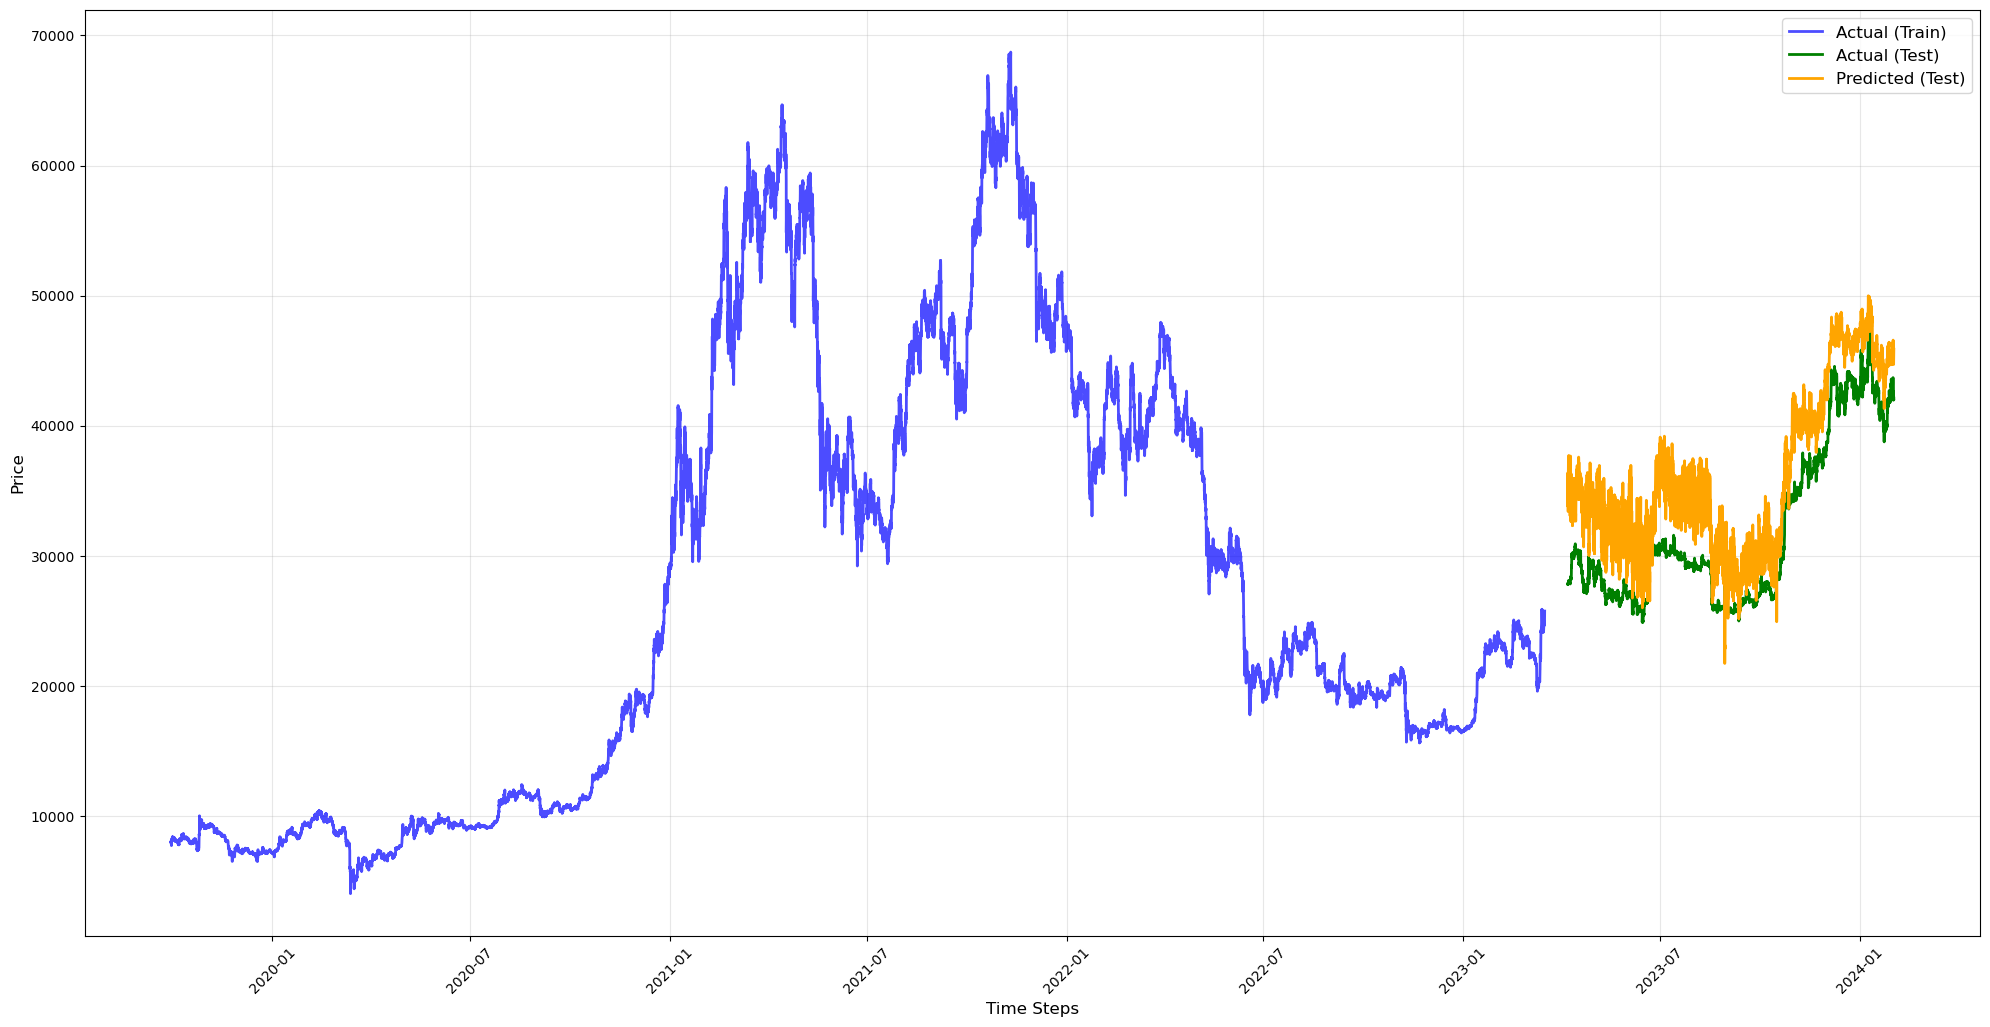

In [22]:
# Visualization of results
plt.figure(figsize=(20, 10))

train_timestamps = TRAIN_DATASET.index
test_timestamps = TEST_DATASET.index

# Plotting the data
# For train data, use actual target values
train_targets = TRAIN_DATASET['target'].values

# Assuming that all_targets and all_preds have the same length
num_test_points = len(all_targets)

# Take the last num_test_points from the test timestamps
aligned_test_timestamps = test_timestamps[-num_test_points:]

# Plotting the data
plt.figure(figsize=(20, 10))
plt.plot(train_timestamps, train_targets, label='Actual (Train)', linewidth=2, color='blue', alpha=0.7)
plt.plot(aligned_test_timestamps, all_targets, label='Actual (Test)', linewidth=2, color='green')
plt.plot(aligned_test_timestamps, all_preds, label='Predicted (Test)', linewidth=2, color='orange')

plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

## **Conclusion**

Based on the evaluation results, the LSTM model performs worse than the GBDT model. Despite attempts to improve performance by increasing model complexity and expanding the hyperparameter search space, these efforts did not yield better results. 

Either a different deep learning architecture should be explored, or further feature engineering is needed to extract more meaningful signals from the data before applying LSTM models.